In [57]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torch.utils.data as data

#plt.style.use("seaborn")
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# good behavior for notebooks!
sns.set(context='notebook' , color_codes=True)
%matplotlib inline

# Finding Higgs Bosons with PyTorch!!

This notebook builds on our previous notebooks in which we were studying the Higgs boson Kaggle challenge.  We've now seen the `scikit-learn` implementation (super simple black box) and we've seen the `Keras + TensorFlow` implementation (simple, but intuitive control of the NN).

This time, we're going to try out PyTorch to give you a feeling for how `PyTorch` connects you much more closely to the tools that build up the NN.  There are a few things specific to `PyTorch` to note, but otherwise we will have a very similar overall picture of what's going on.

# Load the data sample

The first thing to do here is load the data sample.  We will use the `pandas` `dataframe` class, as it's well suited to this task.  For the training sample, we will use the first 350k samples.  The remaining samples will be for validation and evaluation of independent AMS scores.

In [2]:
# read the first 350k samples
dataset=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',nrows=350000)

# summarize the data

# shape
print("Shape:\n",dataset.shape, "\n")


Shape:
 (350000, 35) 



# Now groom the data sample

We need prepare a subset of the sample on which to train.  We will remove all of the variables that should not be used in the training and retain the rest.  In addition, we'll keep a copy of the labels and weights for later.

In [3]:
# Make a new dataframe without some of the features
X = dataset.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weights = dataset['Weight'].values

# We'll find it useful to have the dataframe column names
colNames = X.columns

# Two forms of the 
y = pd.get_dummies(dataset.Label)
yt = y.values[:,0]

# Build selectors to separate our data in to signal and background
sSelector = np.array(yt == 0)
bSelector = np.array(yt == 1)

# Calculate what's in our samples
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

# Normalize weights for signal to match the background in magnitude
nweights = np.copy(weights)
nweights[sSelector] *= sumBWeights/sumSWeights  

# Perform standard scaling!
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X.values)  
Xplot = scaler.transform(X.values)

# Recall that PyTorch uses Tensors for everything!
# Thus we need to convert from numpy arrays to Tensors here.
tX0 = torch.from_numpy(Xplot)
ty0 = torch.from_numpy(y.values[:,1])

# Pytorch likes float for the design matrix and long for targets
tX = tX0.to(torch.float32)
ty = ty0.to(torch.long)

print(tX.shape)
print(ty.shape)

Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966
torch.Size([350000, 30])
torch.Size([350000])


In [4]:
def getRange(sig, bkg):
    ret = np.zeros(2)
    amin = np.min(sig)
    ret[0] = amin
    if amin <-998:
        ret[0] = 0
    vals, bins = np.histogram(sig,bins=100)
    vals2, bins2 = np.histogram(bkg,bins=100)

    ret[1] = np.maximum(np.max(sig),np.max(bkg))

    idx = 0
    for val in vals:
        if val > 2:
            ret[1] = bins[idx+1]
        if vals2[idx] > 2:
            ret[1] = bins2[idx+1]
        idx += 1
        
    if ret[1] < ret[0]:
        ret[1] = np.maximum(np.max(sig),np.max(bkg))
    
    if np.abs(1.0-ret[1])<0.1:
        ret[1] = 1.0
    
    return ret

def plotHisto(sig,bkg,label,ax, doNorm=True, s_weight=None, b_weight=None):
    trange = getRange(sig,bkg)
    
    sweight = None
    bweight = None
    if doNorm == True:
        sweight = s_weight
        bweight = b_weight
    
    sVals, edges = np.histogram(sig,bins=100,range=trange,weights=sweight)
    bVals, edges = np.histogram(bkg,bins=100,range=trange,weights=bweight)
    xvals = np.linspace(trange[0],trange[1],100)
    
    if doNorm:
        ax.plot(xvals,sVals/np.sum(sVals),label="Signal")
        ax.plot(xvals,bVals/np.sum(bVals),label="Bkgd")
        ax.set_title("{}, Normalized".format(label))
    else:
        ax.plot(xvals,sVals,label="Signal")
        ax.plot(xvals,bVals,label="Bkgd")
        ax.set_title("{}, Unnormalized".format(label))
    ax.set_ylim(bottom=0)
    ax.legend()

def plotNNresults(predictions,sSelector,bSelector,weights):
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    plotHisto(predictions[sSelector,1],predictions[bSelector,1],"Neural Nework",
              axs[0],doNorm=False)
    plotHisto(predictions[sSelector,1],predictions[bSelector,1],"Neural Nework",
              axs[1],doNorm=True,b_weight=weights[bSelector],s_weight=weights[sSelector])
    plt.show()

# Build a Dataset and DataLoader

This step was not necessary for our `Keras` or `scikit-learn` models, but note how the specific setup of a `Dataset` and `DataLoader` gives us options to control details of how the data is accessed.

In [108]:
# Derive a simple dataset from the torch.util.data.Dataset class
class higgsDataSet(data.Dataset):
    def __init__(self, X, y, *args, **kwargs):
        super().__init__(*args,**kwargs)
        # X = design matrix
        # y = targets
        self.input = X
        self.target = y
    
    def __getitem__(self,idx):
        ix = self.input[idx]
        iy = self.target[idx]
        return ix, iy
    
    def __len__(self):
        return len(self.input)


# Pass our Tensors to our dataset class
higgsData = higgsDataSet(tX,ty)

# Create a dataloader to allow easy mini-batches and shuffling.
higgsLoader = data.DataLoader(dataset = higgsData, batch_size=500, shuffle=True)

# Build a neural network

Our goal is to correctly classify signal and background events.  There are many ways to approach this, but for now we'll focus on neural networks.  For this exercise, we'll get started by using the Multilayer Perceptron class from `scikit-learn`.  This has become a very nice implementation that can create rather deep networks.  The major downside is that it does not have GPU or TPU support.

For our first step, let's consider that we have 30 features.  This is a relatively large space with many potential correlations, so we'll want to try for a relatively large network.  Let's start off by creating a network with two hidden layers with 30 nodes (neurons) and limit to 50 training cycles.  This will give us a first benchmark for our problem.

In [109]:
# Hyper parameters for our NN structure
l1_nodes = 200
l2_nodes = 30

#Define a NN model.  Note that we first define the layers we want and
# then stitch them together in the forward pass argument.
class higgsModel(nn.Module): 
    def __init__(self, inDim):
        super().__init__()
        # Here we build the layers we want to use later on
        # Note that we want to define dropout here, so that it does the right thing
        # between training and evaluation!
        self.fc1 = nn.Linear(in_features = inDim, out_features = l1_nodes, bias=True)
        self.fc2 = nn.Linear(in_features = l1_nodes, out_features = l2_nodes, bias=True)
        self.fc3 = nn.Linear(in_features = l2_nodes, out_features = 2, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) 
        x = self.dropout(x)
        # I want to use softmax for the output, but the PyTorch cross entropy loss already
        # uses this.  So I leave softmax out of the forward pass, but will use softmax when
        # evaluating.
        x = self.fc3(x)
        return x

# We will control every step of our model training here.
def trainModel(loader, inDim, cWeight = None, verbose=False, sweights=None):
    model = Model(inDim)

    model.train()
    
    # Cross-entropy for PyTorch is log_softmax + log-loss
    loss_fn = nn.CrossEntropyLoss(weight=cWeight)

    # Adam is always a good choice to start.
    # Weight decay = L2 regularization strength, default = 0
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-5)

    nIter = 50
    for t in range(nIter):
        print('')

        # Containers to track average loss and accuracy
        iLoss = 0
        iAcc = 0
        for bIdx, (iBatch, iTarget) in enumerate(loader):
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(iBatch)

            # Compute and print loss.
            loss = loss_fn(y_pred, iTarget)

            # Here we add L1 regularization "by hand"
            l1_lambda = 1e-6
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            # Don't forget to add to the loss
            loss = loss + l1_lambda * l1_norm
    
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()

            # Here I'm summing up my loss over my batches and we'll report the
            # average loss and accuracy with some periodicity next.
            iLoss += loss.item()
            iAcc += accuracy_score(iTarget.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1))
            
            # report progress
            if bIdx % 10 == 0:
                print(f'Training epoch {t} [{bIdx*len(iBatch)}/{len(loader.dataset)}]: \tLoss = {iLoss/(bIdx+1):.5f}, Accuracy: {iAcc/(bIdx+1):.4f}',end='\r')
    
    # return the model so we can use it!
    return model



In [110]:
# We have 2x more background examples than signal examples, so we can account for this.
class_weight = torch.tensor([1,2],dtype=torch.float32)

# Create our model and train it!
modelAll = trainModel(higgsLoader,tX.shape[1],cWeight=class_weight, verbose=False)


Training epoch 0 [345000/350000]: 	Loss = 0.45470, Accuracy: 0.7802
Training epoch 1 [345000/350000]: 	Loss = 0.41617, Accuracy: 0.8070
Training epoch 2 [345000/350000]: 	Loss = 0.40867, Accuracy: 0.8116
Training epoch 3 [345000/350000]: 	Loss = 0.40553, Accuracy: 0.8134
Training epoch 4 [345000/350000]: 	Loss = 0.40288, Accuracy: 0.8152
Training epoch 5 [345000/350000]: 	Loss = 0.40091, Accuracy: 0.8157
Training epoch 6 [345000/350000]: 	Loss = 0.39950, Accuracy: 0.8166
Training epoch 7 [345000/350000]: 	Loss = 0.39860, Accuracy: 0.8169
Training epoch 8 [345000/350000]: 	Loss = 0.39810, Accuracy: 0.8178
Training epoch 9 [345000/350000]: 	Loss = 0.39739, Accuracy: 0.8178
Training epoch 10 [345000/350000]: 	Loss = 0.39677, Accuracy: 0.8182
Training epoch 11 [345000/350000]: 	Loss = 0.39618, Accuracy: 0.8182
Training epoch 12 [345000/350000]: 	Loss = 0.39570, Accuracy: 0.8187
Training epoch 13 [345000/350000]: 	Loss = 0.39549, Accuracy: 0.8185
Training epoch 14 [345000/350000]: 	Loss = 

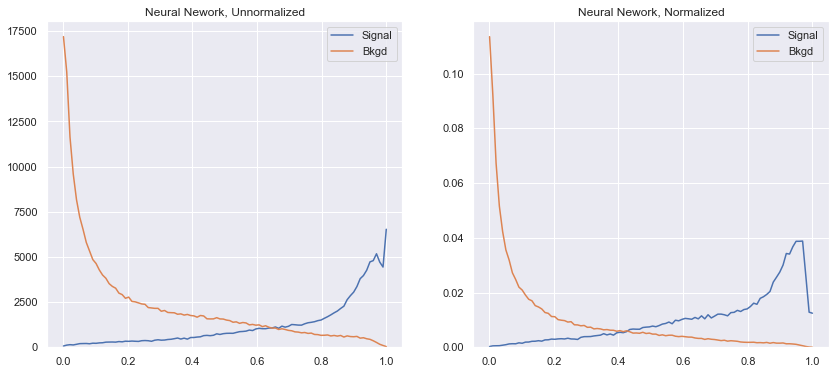

In [111]:
# Very important!!  When we make our predictions, we have to switch our NN over to
# using the evaluation state.  This is because we're using dropout layers and do not
# want to have nodes randomly dropped for this step.
predictionsAll = func.softmax(modelAll.eval()(tX),dim=1)

# Make a plot!
plotNNresults(predictionsAll.detach().numpy(),sSelector,bSelector,weights) 

# Finally, let's check to see how we did for our challenge

The challenge was "judged" based on the Approximate Mean Significance (AMS) score.  Let's just quickly check how we did on our training data.  This is an over-estimate because we trained on this data, but it will give us an idea of how we did!  Remember the best work in the Higgs ML challenge achieved an AMS score of ~ 3.80.

In [38]:
def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0
    
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

def plotAMS(Xa,ya,wa,sel=None):
    yp = ya
    wp = wa
    if sel is not None:
        yp = ya[sel]
        wp = wa[sel]
        
    # order them 
    sSelector = np.array(yp == 0)
    bSelector = np.array(yp == 1)
    
    permute = Xa.argsort()
    sSelector = sSelector[permute]
    bSelector = bSelector[permute]
    Xa = Xa[permute]
    wp = wp[permute]

    # pick out only the signal values
    sVals = Xa[sSelector]
    sigW = wp[sSelector]

    # pick out only the background values
    bVals = Xa[bSelector]
    bkgW = wp[bSelector]

    # make arrays
    xvals = np.linspace(0,1,1000)
    amsV = np.linspace(0,1,1000)
    bkgFrac = np.linspace(0,1,1000)
    aIdx = 0

    # We are going to organize by background rejection fraction,
    # so we need to find those values
    for xx in xvals:
        idxS = bisect.bisect_left(sVals,xx)
        idxB = bisect.bisect_left(bVals,xx)
        amsV[aIdx] = ams(np.sum(sigW[idxS:]),np.sum(bkgW[idxB:]))
        bkgFrac[aIdx] = 1-np.sum(bkgW[idxB:])/np.sum(bkgW)
        aIdx += 1

    permute = bkgFrac.argsort()
    bkgFrac = bkgFrac[permute]
    amsV = amsV[permute]

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(bkgFrac*100,amsV)
    ax.set_xlabel("Background rejection (%)")
    ax.set_ylabel("AMS Score")
    plt.show()
    print("Maximum AMS Value: ",np.max(amsV))

In [112]:
# read the first last ~468k samples
datasetVal=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',skiprows = range(1, 350000))
#datasetVal=pd.read_csv('higgs-boson/training.csv')


# shape
print("Shape:\n",datasetVal.shape, "\n")

# Make a new dataframe without some of the features
Xval = datasetVal.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
#Xval = datasetVal.drop([ 'Label','EventId','Weight'],axis=1,inplace=False)
weightsVal = datasetVal['Weight'].values

# Perform standard scaling!
XplotV = scaler.transform(Xval.values)  

# Two forms of the labels
yv = pd.get_dummies(datasetVal.Label)
yVal = yv.values[:,0]

# Don't for get to Tensor-ize!
tX0 = torch.from_numpy(XplotV)
ty0 = torch.from_numpy(yv.values[:,1])

tXval = tX0.to(torch.float32)
tyval = ty0.to(torch.long)

Shape:
 (468239, 35) 



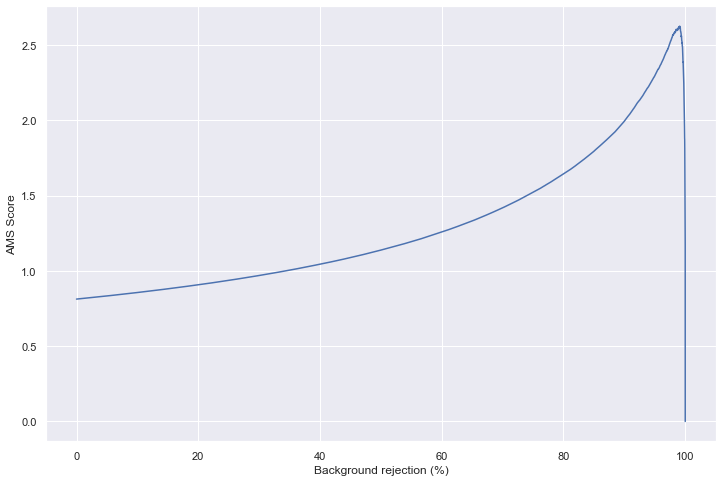

Maximum AMS Value:  2.625694588186174


In [113]:
# Evaluate our new data with the NN
predictionsAll = func.softmax(modelAll.eval()(tXval),dim=1)

# Plot the AMS scores
plotAMS(predictionsAll.detach().numpy()[:,1],yVal,weightsVal)